In [ ]:
# Install data manipulation and visualization libraries
!pip install pandas matplotlib seaborn

# Install machine learning models and tools
!pip install scikit-learn

# Install SHAP for explainability
!pip install shap

# Install LIME for local explainability
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7aff9aefdfccea4915b72b1acdb2267ab7e6677a70da014647e04f9bef6caaa8
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!apt-get install -y graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import shap
from lime.lime_tabular import LimeTabularExplainer
from imblearn.over_sampling import SMOTE  # Importing SMOTE for resampling
import warnings
from graphviz import Digraph  # For creating the flowchart of Stacking Classifier

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
# ## Step 1: Load the Preprocessed Dataset
df = pd.read_csv("/content/drive/MyDrive/CSE475_Lab 3/preprocessed_data.csv")  # Replace with your dataset path
df.head()

,Timestamp,Source_IP,Destination_IP,Protocol,Packet_Length,Duration,Source_Port,Destination_Port,Bytes_Sent,Bytes_Received,...,Avg_Packet_Size,Total_Fwd_Packets,Total_Bwd_Packets,Fwd_Header_Length,Bwd_Header_Length,Sub_Flow_Fwd_Bytes,Sub_Flow_Bwd_Bytes,Inbound,Attack_Type,Label
0,0,6,4,0,1155,4.01,53,53,675,877,...,512,21,34,256,256,697,1028,1,1,1
1,1,7,3,0,1776,3.75,22,22,297,1062,...,1024,14,19,512,256,513,1300,1,1,1
2,2,7,0,2,627,4.24,80,8080,122,723,...,512,10,41,512,256,250,497,0,1,1
3,3,7,0,2,1754,3.09,443,443,1626,1703,...,256,37,44,128,256,985,1471,0,3,0
4,4,6,1,2,1326,2.52,80,443,1851,771,...,1024,40,16,512,256,1877,595,1,2,1


In [ ]:
# ## Step 2: Data Preparation
X = df.drop("Label", axis=1)  # Features
y = df["Label"]  # Target


In [ ]:
# ## Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Step 5: Resampling with SMOTE (if dataset is imbalanced)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# ## Step 6: Define Models
rf_model = RandomForestClassifier(random_state=42)
ab_model = AdaBoostClassifier(algorithm='SAMME', random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Stacking Classifier (Meta-model for stacking)
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('ab', AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=42))
]

# Define meta-learner (Logistic Regression)
meta_learner = LogisticRegression()

# Set up the stacking model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Voting Classifier (ensemble of RF, AdaBoost, and Gradient Boosting)
voting_model = VotingClassifier(estimators=[('rf', rf_model), ('ab', ab_model), ('gb', gb_model)], voting='soft')

In [ ]:
# ## Step 7: Function to Evaluate Models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, confusion

In [ ]:
# ## Step 8: Function to Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, model_name):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Malicious'], yticklabels=['Normal', 'Malicious'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
# ## Step 9: Function to Evaluate and Plot Models
def evaluate_and_plot_models(models, model_names, X_train, y_train, X_test, y_test):
    metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

    for model, model_name in zip(models, model_names):
        print(f"Evaluating {model_name}...")

        accuracy, precision, recall, f1, confusion = evaluate_model(model, X_train, y_train, X_test, y_test)

        metrics['Model'].append(model_name)
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1 Score'].append(f1)

        print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        plot_confusion_matrix(confusion, model_name)

    # Create a DataFrame from the metrics
    metrics_df = pd.DataFrame(metrics)
    print("\nModel Evaluation Metrics:")
    print(metrics_df)

    return metrics_df

Evaluating Random Forest...
Random Forest - Accuracy: 0.5268, Precision: 0.5256, Recall: 0.5268, F1 Score: 0.5257


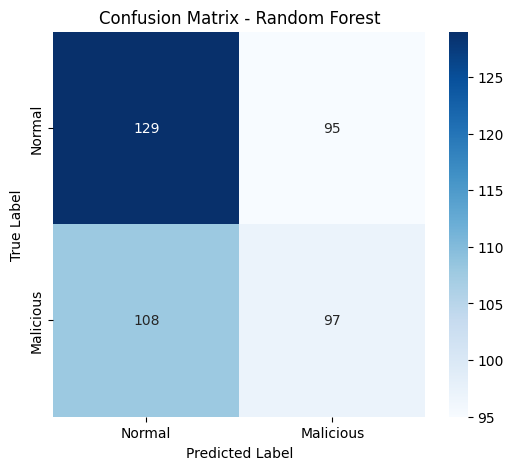

Evaluating AdaBoost...
AdaBoost - Accuracy: 0.5105, Precision: 0.5111, Recall: 0.5105, F1 Score: 0.5107


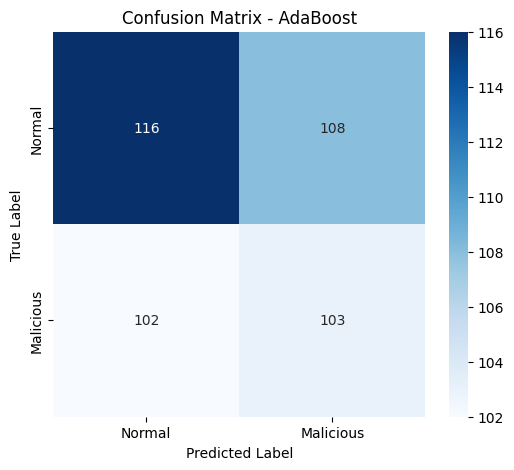

Evaluating Gradient Boosting...
Gradient Boosting - Accuracy: 0.5175, Precision: 0.5170, Recall: 0.5175, F1 Score: 0.5172


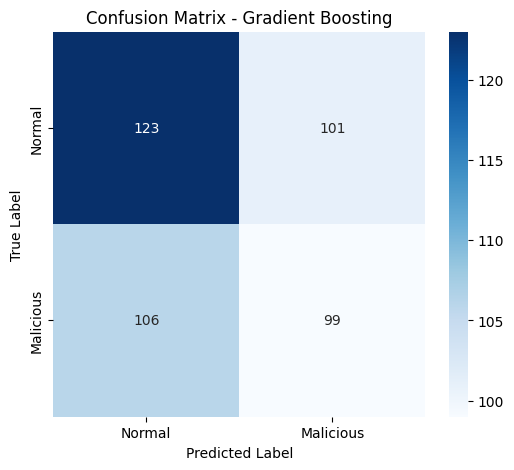

Evaluating Voting Classifier...
Voting Classifier - Accuracy: 0.4918, Precision: 0.4910, Recall: 0.4918, F1 Score: 0.4912


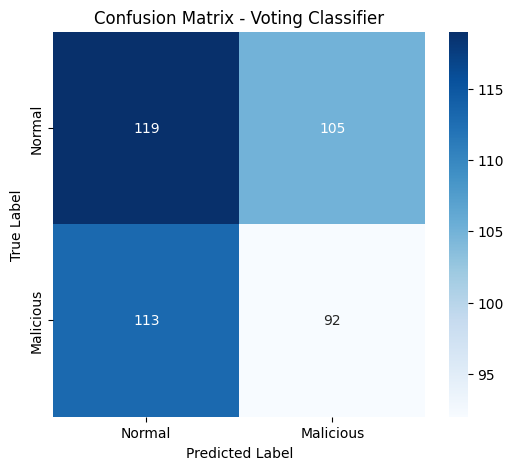

Evaluating Stacking Classifier...
Stacking Classifier - Accuracy: 0.4825, Precision: 0.4833, Recall: 0.4825, F1 Score: 0.4828


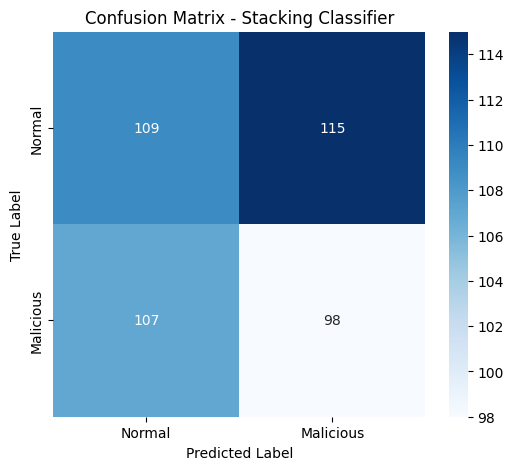


Model Evaluation Metrics:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.526807   0.525622  0.526807  0.525731
1             AdaBoost  0.510490   0.511104  0.510490  0.510697
2    Gradient Boosting  0.517483   0.516992  0.517483  0.517167
3    Voting Classifier  0.491841   0.490985  0.491841  0.491243
4  Stacking Classifier  0.482517   0.483348  0.482517  0.482765


In [ ]:
# Example usage
models = [rf_model, ab_model, gb_model, voting_model, stacking_model]
model_names = ["Random Forest", "AdaBoost", "Gradient Boosting", "Voting Classifier", "Stacking Classifier"]

metrics_df = evaluate_and_plot_models(models, model_names, X_train_resampled, y_train_resampled, X_test, y_test)


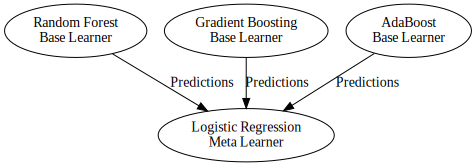

In [ ]:
from graphviz import Digraph

# ## Step 10: Generate the Stacking Classifier Flowchart
def plot_stacking_flowchart():
    dot = Digraph(comment='Stacking Classifier')

    # Define the base learners
    dot.node('RF', 'Random Forest\nBase Learner')
    dot.node('GB', 'Gradient Boosting\nBase Learner')
    dot.node('AB', 'AdaBoost\nBase Learner')

    # Define the final estimator (meta-learner)
    dot.node('LR', 'Logistic Regression\nMeta Learner')

    # Connect the base learners to the final estimator
    dot.edge('RF', 'LR', label='Predictions')
    dot.edge('GB', 'LR', label='Predictions')
    dot.edge('AB', 'LR', label='Predictions')

    # Render the diagram to a file and display it
    dot.render('stacking_classifier_flowchart', format='png', view=True)  # This will generate a PNG and open it

    return dot

# Call the function to generate and view the Stacking flowchart
plot_stacking_flowchart()


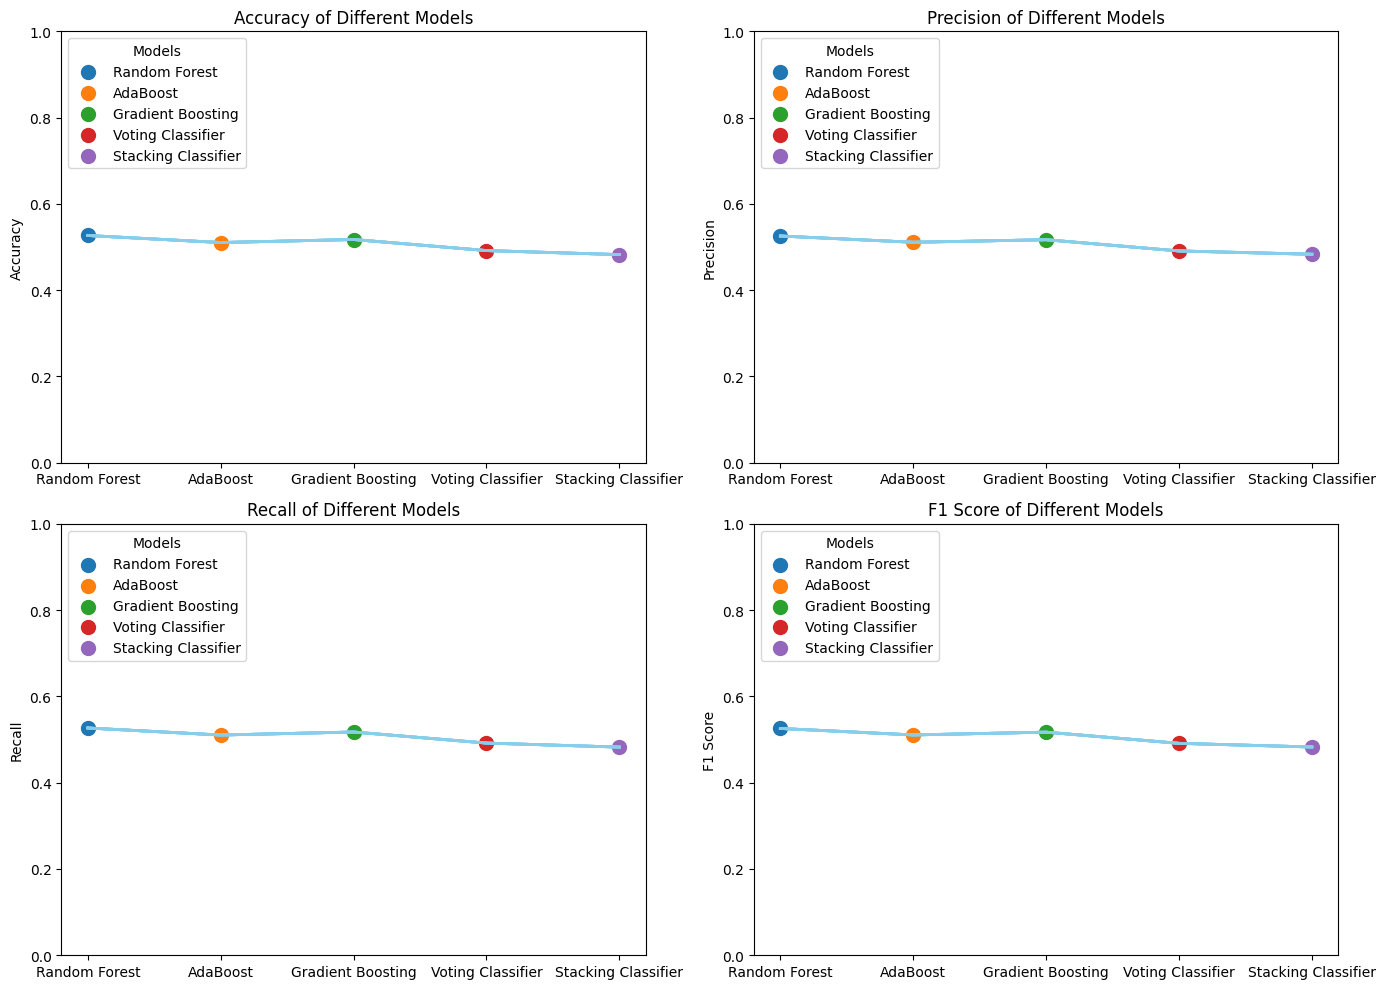

In [ ]:
# ## Step 11: Plot Performance Metrics
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Define unique colors for each model's dots (just the markers)
marker_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Unique colors for markers

# Plot all metrics in line graph format
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    ax_row, ax_col = divmod(i, 2)

    # Plot the line for each model (same color for all lines, gray)
    for j, model_name in enumerate(metrics_df['Model']):
        ax[ax_row, ax_col].plot(metrics_df['Model'], metrics_df[metric],
                                linestyle='-', linewidth=2, color='skyblue')  # Plot all lines in gray

    # Plot the dots separately, each with a unique color
    for j, model_name in enumerate(metrics_df['Model']):
        ax[ax_row, ax_col].scatter(model_name, metrics_df[metrics_df['Model'] == model_name][metric].values[0],
                                    color=marker_colors[j], s=100, label=model_name)  # Color dots individually

    # Set titles, labels, and limits
    ax[ax_row, ax_col].set_title(f'{metric} of Different Models')
    ax[ax_row, ax_col].set_ylabel(metric)
    ax[ax_row, ax_col].set_ylim([0, 1])  # Ensure metrics are in the range [0, 1]
    ax[ax_row, ax_col].legend(loc='upper left', title="Models")

# Improve layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Import display for better table rendering in Jupyter Notebooks or interactive environments
from IPython.display import display

# Adjust pandas display settings to show the entire table with better formatting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set width to avoid truncation
pd.set_option('display.max_colwidth', None)  # Show full content in each column

# ## Step 10: Cross-Validation - Display Results in Table Format
cross_val_results = {'Model': [], 'Fold Scores': [], 'Mean Score': []}

# Loop through each model and perform cross-validation
for model, model_name in zip(models, model_names):
    cross_val_scores = cross_val_score(model, X, y, cv=5)

    # Append results to the dictionary
    cross_val_results['Model'].append(model_name)
    cross_val_results['Fold Scores'].append(cross_val_scores)
    cross_val_results['Mean Score'].append(cross_val_scores.mean())

# Convert results into a DataFrame
cross_val_df = pd.DataFrame(cross_val_results)

# Display the cross-validation results in table format
display(cross_val_df)


,Model,Fold Scores,Mean Score
0,Random Forest,"[0.4825174825174825, 0.5, 0.5314685314685315, 0.5, 0.4825174825174825]",0.499301
1,AdaBoost,"[0.5104895104895105, 0.47202797202797203, 0.493006993006993, 0.5, 0.513986013986014]",0.497902
2,Gradient Boosting,"[0.5, 0.5314685314685315, 0.5104895104895105, 0.44755244755244755, 0.5104895104895105]",0.500000
3,Voting Classifier,"[0.5104895104895105, 0.4965034965034965, 0.527972027972028, 0.46853146853146854, 0.47202797202797203]",0.495105
4,Stacking Classifier,"[0.48951048951048953, 0.5209790209790209, 0.5104895104895105, 0.513986013986014, 0.527972027972028]",0.512587


SHAP Analysis for Random Forest...


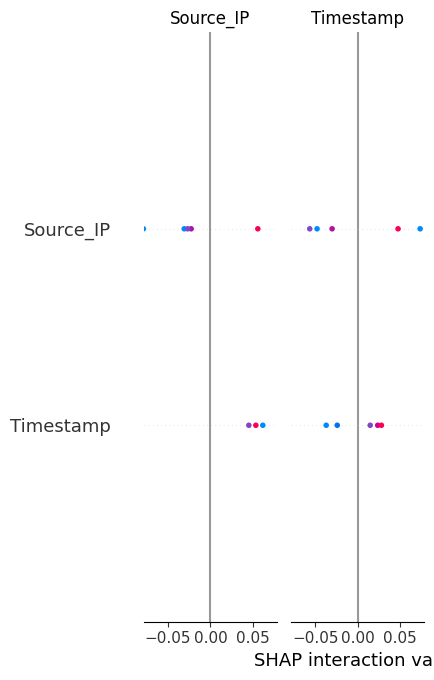

SHAP Analysis for Gradient Boosting...


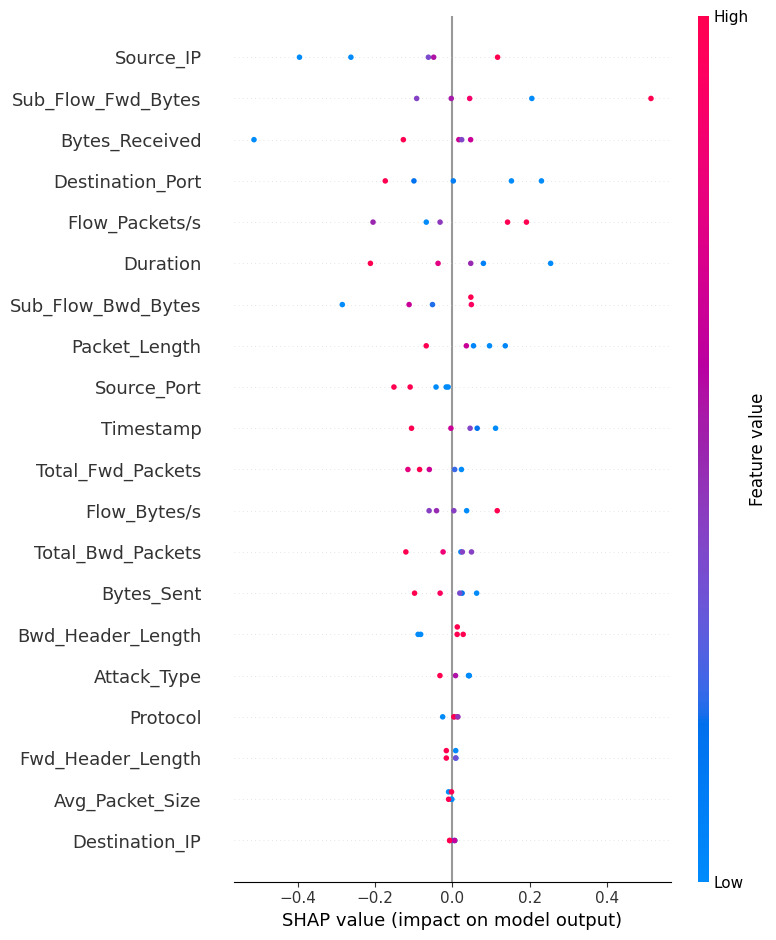

SHAP Analysis for AdaBoost...


  0%|          | 0/5 [00:00<?, ?it/s]

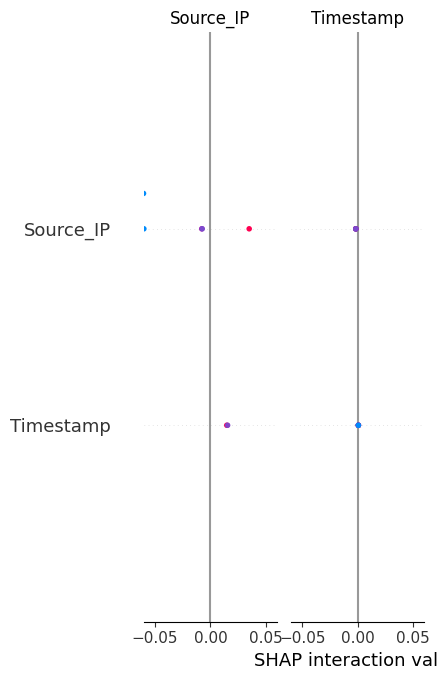

SHAP Analysis for Voting Classifier...


  0%|          | 0/5 [00:00<?, ?it/s]

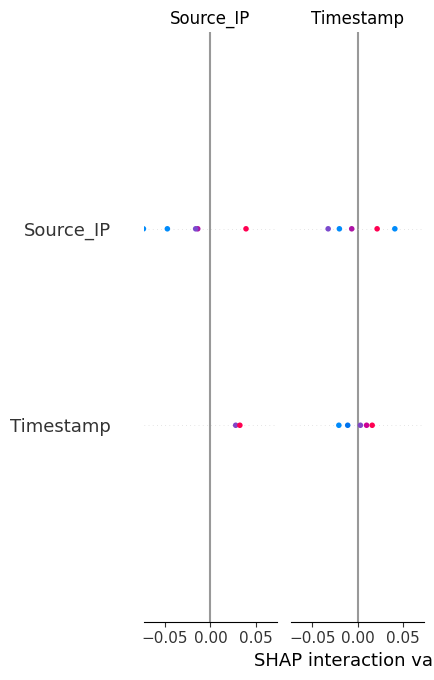

SHAP Analysis for Stacking Classifier...


  0%|          | 0/5 [00:00<?, ?it/s]

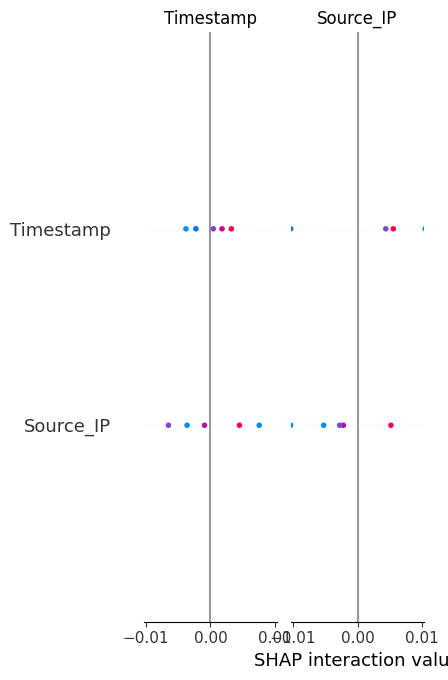

In [ ]:
# ## Step 11: SHAP - Model Explainability
for model, model_name in zip([rf_model, gb_model], ["Random Forest", "Gradient Boosting"]):
    print(f"SHAP Analysis for {model_name}...")
    explainer = shap.TreeExplainer(model)
    background_data = shap.sample(X_train, 5)
    shap_values = explainer.shap_values(background_data)
    shap.summary_plot(shap_values, background_data)

for model, model_name in zip([ab_model, voting_model, stacking_model], ["AdaBoost", "Voting Classifier", "Stacking Classifier"]):
    print(f"SHAP Analysis for {model_name}...")
    explainer = shap.KernelExplainer(model.predict_proba, X_train)
    background_data = shap.sample(X_train, 5)
    shap_values = explainer.shap_values(background_data)
    shap.summary_plot(shap_values, background_data)

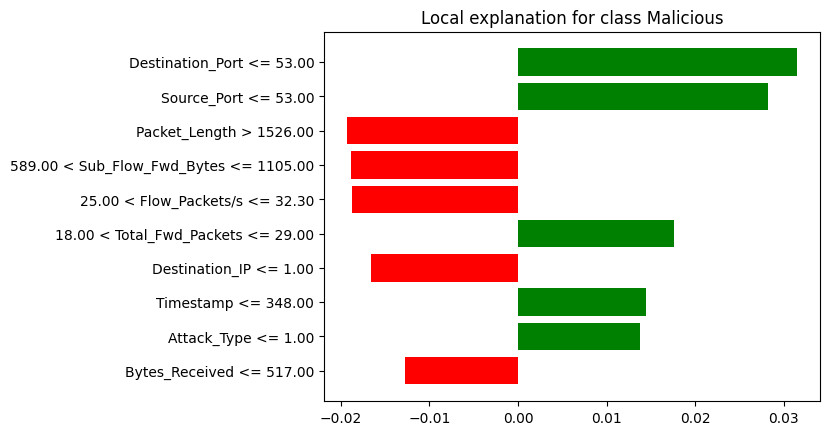

In [ ]:
# ## Step 12: LIME - Local Interpretable Model-Agnostic Explanations
explainer_lime = LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['Normal', 'Malicious'], discretize_continuous=True)

idx = np.random.randint(0, X_test.shape[0])
explanation = explainer_lime.explain_instance(X_test.iloc[idx].values, rf_model.predict_proba, num_features=10)
fig = explanation.as_pyplot_figure()
plt.show()

In [ ]:
# ## Step 13: Total Summary of Code Performance Results

# Find the best model based on each metric
best_accuracy_model = metrics_df.loc[metrics_df['Accuracy'].idxmax()]['Model']
best_precision_model = metrics_df.loc[metrics_df['Precision'].idxmax()]['Model']
best_recall_model = metrics_df.loc[metrics_df['Recall'].idxmax()]['Model']
best_f1_model = metrics_df.loc[metrics_df['F1 Score'].idxmax()]['Model']

# Print the total summary table
print("\n### Total Summary of Performance Results ###")
total_summary = pd.DataFrame({
    'Metric': ['Best Accuracy', 'Best Precision', 'Best Recall', 'Best F1 Score'],
    'Model': [best_accuracy_model, best_precision_model, best_recall_model, best_f1_model]
})

print(total_summary)


### Total Summary of Performance Results ###
           Metric          Model
0   Best Accuracy  Random Forest
1  Best Precision  Random Forest
2     Best Recall  Random Forest
3   Best F1 Score  Random Forest


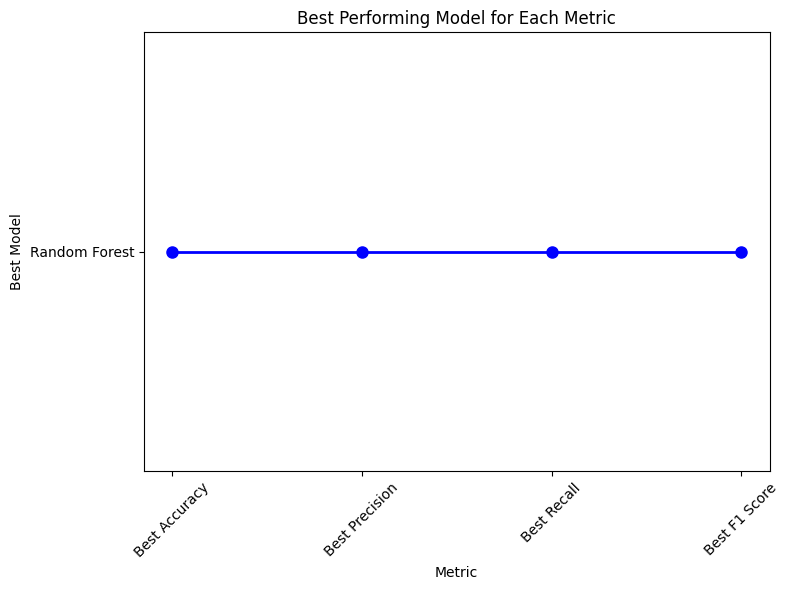

In [ ]:
# ## Step 14: Plot Total Summary (Best Model for Each Metric)
# Create a line plot for the best model for each metric

fig, ax = plt.subplots(figsize=(8, 6))
total_summary.set_index('Metric', inplace=True)

# Plot the best models for each metric
ax.plot(total_summary.index, total_summary['Model'], marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Formatting the plot
ax.set_title('Best Performing Model for Each Metric')
ax.set_ylabel('Best Model')
ax.set_xlabel('Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()